In [12]:
!pip install toolz scikit-allel

import os
import numpy as np
import pandas as pd
import ast
import math
import re
import itertools
import random
import json
import matplotlib
from matplotlib.pyplot import plot as plt
from scipy.spatial.distance import squareform
from pylab import *
mpl.use("pgf")
# activate latex text rendering
rc('text', usetex=True)
rc('axes', linewidth=2)
rc('font', weight='bold')
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'text.latex.preamble':r'\usepackage{sfmath} \boldmath'
})
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import allel
# sns.set_theme(style="ticks")


You should consider upgrading via the 'c:\users\sleepy\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [13]:
# load data
root_dir = './data/'
new_data_header = ""
# get header
with open(root_dir + "HLA.recode.vcf", 'r') as f_in:
    # skip info
    for line_num in range(252):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "HLA.recode.vcf",
                        comment='#', sep='\t',
                        names=new_data_header.strip().split('\t'),
                        header=None).iloc[:, 9:].T

headers = genotypes.columns[:]
genotypes

,0,1,2,3,4,5,6,7,8,9,...,7151,7152,7153,7154,7155,7156,7157,7158,7159,7160
HG00096,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,1|0,1|0,0|0,1|0,0|0,0|0,0|0,0|0,1|0,...,0|1,0|1,0|1,0|1,0|0,0|1,0|1,0|1,0|1,0|0
HG00099,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,1|1,1|1,1|1,1|1,0|0,1|1,1|1,1|1,1|1,0|0
HG00100,0|0,0|1,0|1,0|0,0|1,0|0,0|0,0|0,0|0,0|1,...,0|1,0|1,0|1,0|1,0|0,0|1,0|1,0|1,0|1,0|0
HG00101,0|0,1|1,1|0,0|0,1|0,0|0,0|0,0|0,0|0,1|0,...,1|0,1|0,1|0,1|0,0|0,1|0,1|0,1|0,1|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,1|1,1|1,0|0,1|1,0|0,0|0,0|0,0|0,1|1,...,1|0,1|0,0|0,1|0,1|0,0|0,0|0,1|0,0|0,0|0
NA21142,0|0,1|1,0|1,0|0,0|1,0|0,0|0,0|0,0|0,0|1,...,0|1,0|1,0|1,0|1,0|0,0|1,0|1,0|1,0|1,0|0
NA21143,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,1|1,1|1,1|1,1|1,0|0,1|1,1|1,1|1,1|1,0|0


In [14]:
ped_file = 'integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(root_dir+ped_file, sep='\t', index_col='Individual ID')
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [15]:
Y_train = pedigree.loc[genotypes.index]['Population']
X = genotypes[genotypes.index.isin(Y_train.index)]
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2504, 7161)

(array([1763., 1946., 1297.,  917., 1238.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
 <BarContainer object of 5 artists>)

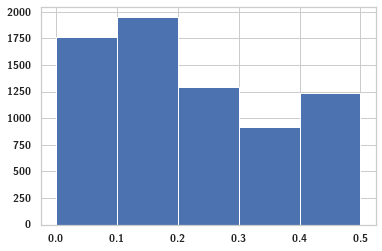

In [16]:
def freq_mapper(g):
  return 0 if g == 0 else 1 if g==1 or g==2 else 2

def maf_mapper(g):
  return min(g, 1-g)

_X = X.applymap(freq_mapper)
_X = _X.sum(axis=0)/(2*X.shape[0])
mafs = _X.map(maf_mapper)
plt.hist(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5])

In [17]:
bin_labels = np.digitize(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5], right=True)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5], dtype=int64),
 array([1763, 1946, 1297,  917, 1238], dtype=int64))

In [21]:
columns = ["Fold", "MissingRate", "MAF", "Accuracy", "Sample ID"]
dfs = []

N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.01,
                       0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    print(f"Missing rate: {missing_perc}")
    file_name = f"./experimental_results/hla/maf/Minimac4/preds_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace({
        '0|0': 0,
        '0|1': 1,
        '1|0': 2,
        '1|1': 3
    })
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels
                                            )
        # for mi in missing_index:
        #     maf_bin_label = maf_bin_labels[mi]
        #     df.loc[-1] = [fold, missing_perc, maf_bin_label, int(yhat[i, mi]==y[i, mi])]
        #     df.index += 1
        a = np.reshape(bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

print("Combining the results...")
df = pd.concat(dfs, ignore_index=True)
del dfs

df["MAF"] = df["MAF"].replace({
    1.0: '0 <= MAF < 0.1',
    2.0: '0.1 <= MAF < 0.2',
    3.0: '0.2 <= MAF < 0.3',
    4.0: '0.3 <= MAF < 0.4',
    5.0: '0.4 <= MAF <= 0.5',
})
df

Fold: 1
Missing rate: 0.01


100%|██████████| 835/835 [00:02<00:00, 300.55it/s]


Missing rate: 0.05


100%|██████████| 835/835 [00:07<00:00, 107.19it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:14<00:00, 58.91it/s] 


Missing rate: 0.2


100%|██████████| 835/835 [00:25<00:00, 32.77it/s]


Fold: 2
Missing rate: 0.01


100%|██████████| 835/835 [00:02<00:00, 321.45it/s]


Missing rate: 0.05


100%|██████████| 835/835 [00:07<00:00, 109.92it/s]


Missing rate: 0.1


100%|██████████| 835/835 [00:13<00:00, 61.30it/s]


Missing rate: 0.2


100%|██████████| 835/835 [00:25<00:00, 32.73it/s]


Fold: 3
Missing rate: 0.01


100%|██████████| 834/834 [00:02<00:00, 303.08it/s]


Missing rate: 0.05


100%|██████████| 834/834 [00:07<00:00, 109.02it/s]


Missing rate: 0.1


100%|██████████| 834/834 [00:13<00:00, 60.81it/s] 


Missing rate: 0.2


100%|██████████| 834/834 [00:25<00:00, 33.11it/s]


Combining the results...


12it [00:00, 12.09it/s]


,Fold,MissingRate,MAF,Accuracy,Sample ID
0,1,0.01,0.4 <= MAF <= 0.5,1,NA21144
1,1,0.01,0 <= MAF < 0.1,1,NA21144
2,1,0.01,0.1 <= MAF < 0.2,1,NA21144
3,1,0.01,0.4 <= MAF <= 0.5,1,NA21144
4,1,0.01,0.4 <= MAF <= 0.5,1,NA21144
...,...,...,...,...,...
6452803,3,0.2,0.3 <= MAF < 0.4,1,HG00097
6452804,3,0.2,0 <= MAF < 0.1,1,HG00097
6452805,3,0.2,0.3 <= MAF < 0.4,1,HG00097
6452806,3,0.2,0.4 <= MAF <= 0.5,1,HG00097


In [22]:
df.to_csv("results_in_table/hla/maf/maf_minimac4.csv")

In [28]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"})
df1

Accuracy
Fold MissingRate          
1    0.01         0.993641
     0.05         0.993514
     0.10         0.993340
     0.20         0.993031
2    0.01         0.993219
     0.05         0.993363
     0.10         0.993017
     0.20         0.992757
3    0.01         0.993566
     0.05         0.993479
     0.10         0.993306
     0.20         0.993149

In [29]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.01         0.993475  0.000225
0.05         0.993452  0.000079
0.10         0.993221  0.000178
0.20         0.992979  0.000201

In [27]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                                   mean       std
MissingRate MAF                                  
0.01        0 <= MAF < 0.1     0.996273  0.060939
            0.1 <= MAF < 0.2   0.994976  0.070699
            0.2 <= MAF < 0.3   0.991951  0.089354
            0.3 <= MAF < 0.4   0.986289  0.116293
            0.4 <= MAF <= 0.5  0.993943  0.077592
0.05        0 <= MAF < 0.1     0.996261  0.061037
            0.1 <= MAF < 0.2   0.995187  0.069208
            0.2 <= MAF < 0.3   0.991620  0.091161
            0.3 <= MAF < 0.4   0.987342  0.111794
            0.4 <= MAF <= 0.5  0.993204  0.082155
0.10        0 <= MAF < 0.1     0.996136  0.062043
            0.1 <= MAF < 0.2   0.994969  0.070752
            0.2 <= MAF < 0.3   0.991030  0.094286
            0.3 <= MAF < 0.4   0.987524  0.110996
            0.4 <= MAF <= 0.5  0.992873  0.084122
0.20        0 <= MAF < 0.1     0.996035  0.062846
            0.1 <= MAF < 0.2   0.994776  0.072085
            0.2 <= MAF < 0.3   0.990805  0.095446
            0.3 <= MAF < 0.4   0.986919  0.113621
            0.4 <= MAF <= 0.5  0.992551  0.085988